In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "IGH_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-GC2-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-GC4-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-GC1-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-GC3-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-GC-IGH_HUMAN-after-reassignment.csv']

In [3]:
# Exclude cdr3-clones-GC-IGH_HUMAN-after-reassignment.csv
myfiles.remove('cdr3-clones-GC-IGH_HUMAN-after-reassignment.csv')
myfiles

['cdr3-clones-GC2-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-GC4-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-GC1-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-GC3-IGH_HUMAN-after-reassignment.csv']

In [4]:
pt_file="20201007-Maria-pt-table-new.csv"
run = "runMaria1234"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: runMaria1234-similarity-IGH_HUMAN.pdf


## Import clonesdata

In [5]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [6]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,MS-200109-13_S13,nomatch,CARGRGSGSWNFDYWGQGTLVT,1199,1,IGHV1-2+IGHV1-8,IGHJ4,820,0.683903,0.737901,0.008252
1,MS-200109-13_S13,nomatch,CAHGMARPRQWDTVVDFDYWGQGTLVT,1181,1,IGHV2-5,IGHJ4,108,0.091448,0.726823,0.008252
2,MS-200109-13_S13,nomatch,CARPSSSYSSSLDYWGQGTLVT,622,1,IGHV5-51,IGHJ4,79,0.127010,0.382797,0.008252
3,MS-200109-13_S13,nomatch,CARGRGSGWLLDYWGQGTLVT,525,1,IGHV1-2+IGHV1-8,IGHJ4,318,0.605714,0.323101,0.008252
4,MS-200109-13_S13,nomatch,CARSLDPLDFQHWGQGTLVT,487,1,IGHV1-18+IGHV1-2,IGHJ1,30,0.061602,0.299714,0.008252


In [7]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
69915,MS-85_S10,CAREGRSRGRPPNYYYGMDVWGQGTTVT,70479,1,451,0.006399,77.374627,0.018454
71537,MS-85_S10,CARSNITMIGINDLWGQGTLVT,911,1,1763,1.935236,1.000132,0.018454
69337,MS-85_S10,CARDPQSITGLDYWGQGTLVT,550,1,7,0.012727,0.603812,0.018454
69175,MS-85_S10,CARDLGGNFDYWGQGTLVT,484,1,10,0.020661,0.531354,0.018454
68051,MS-85_S10,CAKDSYSSSLRFGDGQGTLVT,418,1,2,0.004785,0.458897,0.018454


## Import patient table

In [8]:
pt = pd.read_csv(pt_file, sep=",")
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Sample_ID,Sample_Name,Sample_Plate,Sample_Well,I7_Index_ID,index,I5_Index_ID,index2,Run,Nr,Sample_Project,Species,Chain,Patient,SampleInfo,UMI,filename
0,MS-200109-1,MS-200109-1,NaN,NaN,NaN,NaN,NaN,NaN,RUNMARIA,S1,GC,human,BCRh,tonsil,NaN,no,MS-200109-1_S1_L001_R1_001.fastq.gz
1,MS-200109-2,MS-200109-2,NaN,NaN,NaN,NaN,NaN,NaN,RUNMARIA,S2,GC,human,BCRh,GC1,NaN,no,MS-200109-2_S2_L001_R1_001.fastq.gz
2,MS-200109-3,MS-200109-3,NaN,NaN,NaN,NaN,NaN,NaN,RUNMARIA,S3,GC,human,BCRh,GC2,NaN,no,MS-200109-3_S3_L001_R1_001.fastq.gz
3,MS-200109-4,MS-200109-4,NaN,NaN,NaN,NaN,NaN,NaN,RUNMARIA,S4,GC,human,BCRh,GC3,NaN,no,MS-200109-4_S4_L001_R1_001.fastq.gz
4,MS-200109-5,MS-200109-5,NaN,NaN,NaN,NaN,NaN,NaN,RUNMARIA,S5,GC,human,BCRh,GC4,NaN,no,MS-200109-5_S5_L001_R1_001.fastq.gz


In [9]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample_Name'], pt['Nr'])]
pt = pt[["Sample","Patient"]]

In [10]:
pt.head()

,Sample,Patient
0,MS-200109-1_S1,tonsil
1,MS-200109-2_S2,GC1
2,MS-200109-3_S3,GC2
3,MS-200109-4_S4,GC3
4,MS-200109-5_S5,GC4


## Merge clones with pt

In [11]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,MS-85_S10,CAREGRSRGRPPNYYYGMDVWGQGTTVT,70479,1,451,0.006399,77.374627,0.018454,Unknown
1,MS-85_S10,CARSNITMIGINDLWGQGTLVT,911,1,1763,1.935236,1.000132,0.018454,Unknown
2,MS-85_S10,CARDPQSITGLDYWGQGTLVT,550,1,7,0.012727,0.603812,0.018454,Unknown
3,MS-85_S10,CARDLGGNFDYWGQGTLVT,484,1,10,0.020661,0.531354,0.018454,Unknown
4,MS-85_S10,CAKDSYSSSLRFGDGQGTLVT,418,1,2,0.004785,0.458897,0.018454,Unknown


## Determine distance between samples

In [12]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                           C_1              GC1                 \
Sample                 MS-200109-8_S8 MS-200109-14_S14 MS-200109-2_S2   
cdr3pep                                                                 
AWGYWGQGTLVT                      0.0              0.0            0.0   
CAAAELGLINYFDYSGQGTLVT            0.0              0.0            0.0   
CAAAELGLINYFDYWGQGTLVT            0.0              0.0            0.0   
CAAAFLMTHNWFDPWGQGTLVT            0.0              0.0            0.0   
CAAAFLVTHNCFDPWGQGTLVT            0.0              0.0            0.0   

Patient                                       GC10              GC2  \
Sample                 MS-21_S1 MS-22_S2 MS-40_S16 MS-200109-15_S15   
cdr3pep                                                               
AWGYWGQGTLVT                0.0      0.0       0.0              0.0   
CAAAELGLINYFDYSGQGTLVT      0.0      0.0       0.0              0.0   
CAAAELGLINYFDYWGQGTLVT      0.0      0.0       0.0              0.0   
CAAAFLMTHNWFDPWGQGTLVT      0.0      0.0       0.0              0.0   
CAAAFLVTHNCFDPWGQGTLVT      0.0      0.0       0.0              0.0   

Patient                                                  ...  Unknown  \
Sample                 MS-200109-3_S3 MS-23_S3 MS-24_S4  ... MS-79_S4   
cdr3pep                                                  ...            
AWGYWGQGTLVT                      0.0      0.0      0.0  ...      0.0   
CAAAELGLINYFDYSGQGTLVT            0.0      0.0      0.0  ...      0.0   
CAAAELGLINYFDYWGQGTLVT            0.0      0.0      0.0  ...      0.0   
CAAAFLMTHNWFDPWGQGTLVT            0.0      0.0      0.0  ...      0.0   
CAAAFLVTHNCFDPWGQGTLVT            0.0      0.0      0.0  ...      0.0   

Patient                                                               tonsil  \
Sample                 MS-82_S7 MS-83_S8 MS-84_S9 MS-85_S10 MS-200109-13_S13   
cdr3pep                                                                        
AWGYWGQGTLVT                0.0      0.0      0.0       4.0              0.0   
CAAAELGLINYFDYSGQGTLVT      0.0      0.0      0.0       0.0              1.0   
CAAAELGLINYFDYWGQGTLVT      0.0      0.0      0.0       0.0             27.0   
CAAAFLMTHNWFDPWGQGTLVT      0.0      0.0      0.0       0.0              1.0   
CAAAFLVTHNCFDPWGQGTLVT      0.0      0.0      0.0       0.0              0.0   

Patient                                                unknown            
Sample                 MS-200109-1_S1 MS-200109-7_S7 MS-41_S17 MS-42_S18  
cdr3pep                                                                   
AWGYWGQGTLVT                      0.0            0.0       0.0       0.0  
CAAAELGLINYFDYSGQGTLVT            0.0            0.0       0.0       0.0  
CAAAELGLINYFDYWGQGTLVT            0.0            0.0       0.0       0.0  
CAAAFLMTHNWFDPWGQGTLVT            0.0            0.0       0.0       0.0  
CAAAFLVTHNCFDPWGQGTLVT            0.0            3.0       0.0       0.0  

[5 rows x 42 columns]

In [13]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                             C_1              GC1                 \
Sample                   MS-200109-8_S8 MS-200109-14_S14 MS-200109-2_S2   
Patient Sample                                                            
C_1     MS-200109-8_S8          1.00000         0.000020       0.000000   
GC1     MS-200109-14_S14        0.00002         1.000000       0.009798   
        MS-200109-2_S2          0.00000         0.009798       1.000000   
        MS-21_S1                0.00000         0.000000       0.000000   
        MS-22_S2                0.00000         0.000000       0.000000   

Patient                                         GC10              GC2  \
Sample                   MS-21_S1 MS-22_S2 MS-40_S16 MS-200109-15_S15   
Patient Sample                                                          
C_1     MS-200109-8_S8        0.0      0.0       0.0         0.000000   
GC1     MS-200109-14_S14      0.0      0.0       0.0         0.000000   
        MS-200109-2_S2        0.0      0.0       0.0         0.000000   
        MS-21_S1              1.0      0.0       0.0         0.000000   
        MS-22_S2              0.0      1.0       0.0         0.000007   

Patient                                                    ...  Unknown  \
Sample                   MS-200109-3_S3 MS-23_S3 MS-24_S4  ... MS-79_S4   
Patient Sample                                             ...            
C_1     MS-200109-8_S8         0.024039      0.0      0.0  ...      0.0   
GC1     MS-200109-14_S14       0.000000      0.0      0.0  ...      0.0   
        MS-200109-2_S2         0.000026      0.0      0.0  ...      0.0   
        MS-21_S1               0.000000      0.0      0.0  ...      0.0   
        MS-22_S2               0.000000      0.0      0.0  ...      0.0   

Patient                                                          \
Sample                   MS-82_S7  MS-83_S8  MS-84_S9 MS-85_S10   
Patient Sample                                                    
C_1     MS-200109-8_S8    0.00001  0.000039  0.000135  0.003312   
GC1     MS-200109-14_S14  0.00000  0.000000  0.000000  0.000088   
        MS-200109-2_S2    0.00000  0.000000  0.000011  0.000059   
        MS-21_S1          0.00000  0.000000  0.000000  0.000000   
        MS-22_S2          0.00000  0.000000  0.000000  0.000000   

Patient                            tonsil                                \
Sample                   MS-200109-13_S13 MS-200109-1_S1 MS-200109-7_S7   
Patient Sample                                                            
C_1     MS-200109-8_S8           0.019492       0.026194       0.025382   
GC1     MS-200109-14_S14         0.001837       0.000539       0.000352   
        MS-200109-2_S2           0.000042       0.000067       0.000106   
        MS-21_S1                 0.000000       0.000000       0.000000   
        MS-22_S2                 0.000000       0.000000       0.000000   

Patient                    unknown            
Sample                   MS-41_S17 MS-42_S18  
Patient Sample                                
C_1     MS-200109-8_S8         0.0       0.0  
GC1     MS-200109-14_S14       0.0       0.0  
        MS-200109-2_S2         0.0       0.0  
        MS-21_S1               0.0       0.0  
        MS-22_S2               0.0       0.0  

[5 rows x 42 columns]

In [14]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote runMaria1234-similarity-IGH_HUMAN.xlsx to disk


## Create a heatmap

In [15]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [16]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 5.161729902170009e-06
max value: 1.0
Wrote runMaria1234-similarity-IGH_HUMAN.pdf to disk


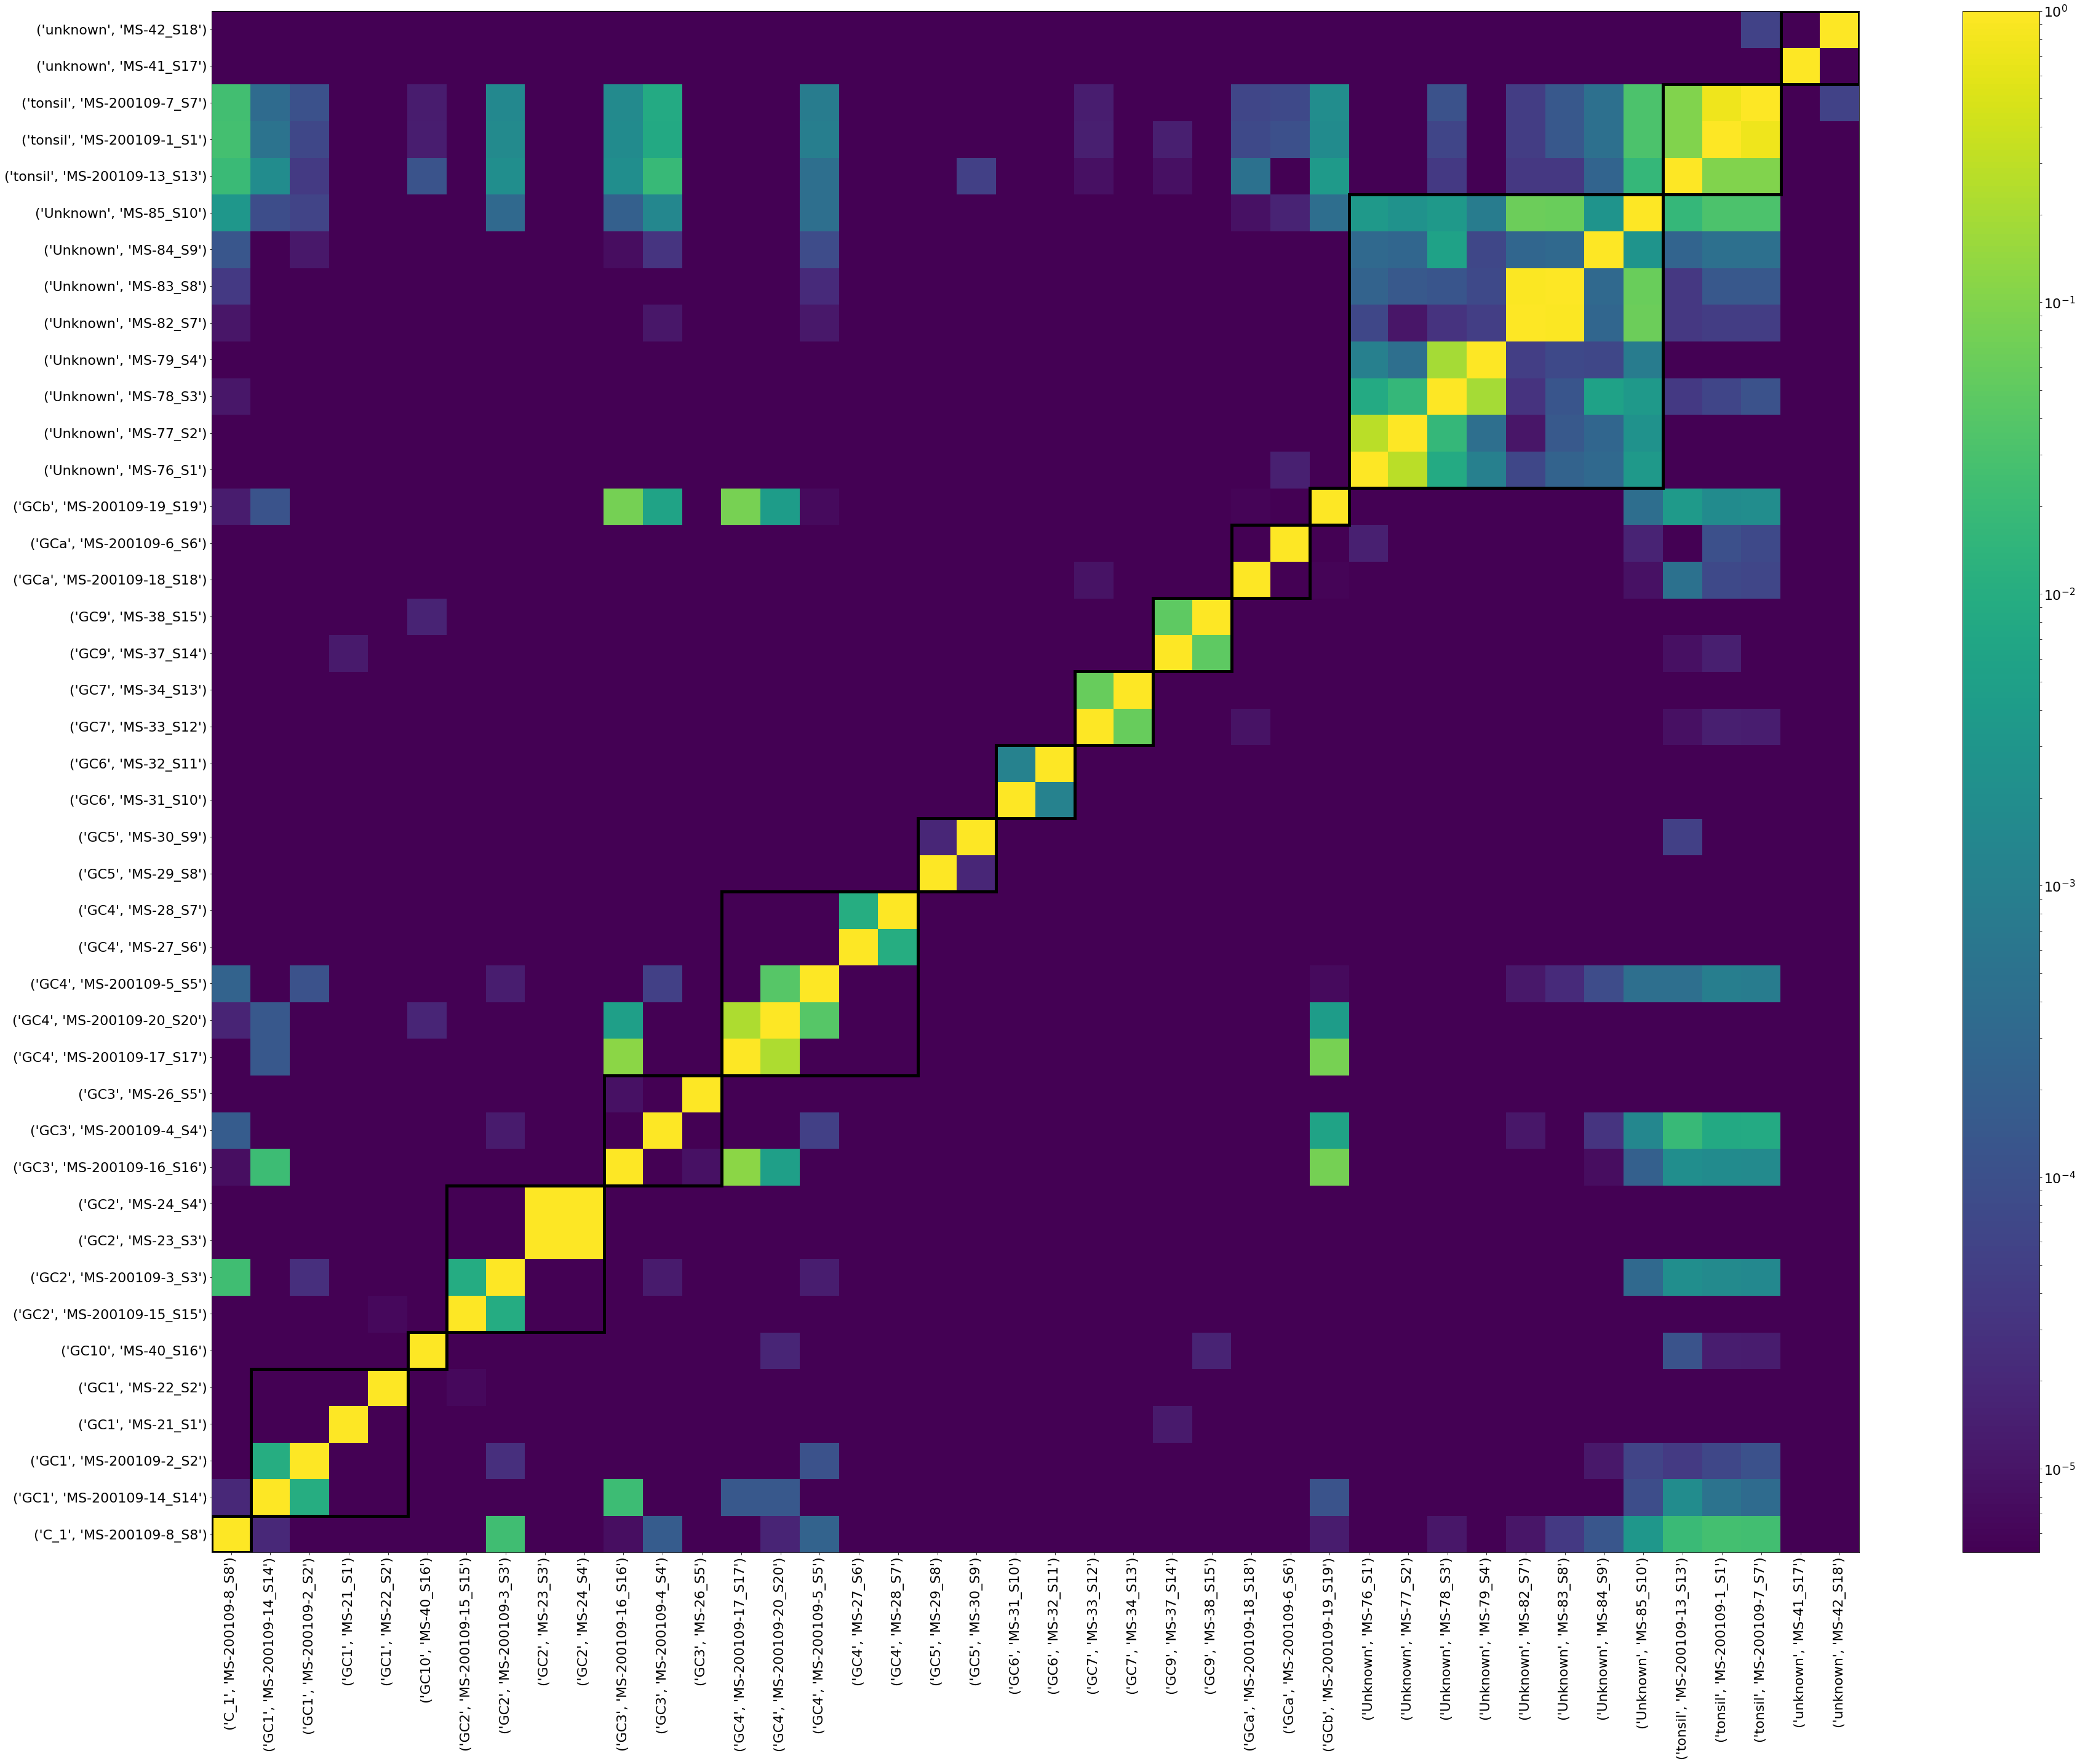

In [17]:
drawHeatmap(sim)

## Highlight anomalies

In [18]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [19]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.06309318824228725 0.19442593195587018
mean diff patient 0.000711197930492713 0.006430535498872172
threshold 0.026433339925981403


{'boxes': [<matplotlib.lines.Line2D at 0x7f63be531cc0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f63be53b710>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f63be5443c8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f63be53bf60>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f63be531e10>,
  <matplotlib.lines.Line2D at 0x7f63be54d0b8>]}

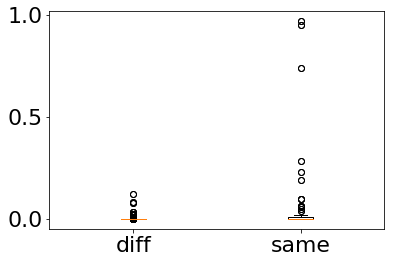

In [20]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

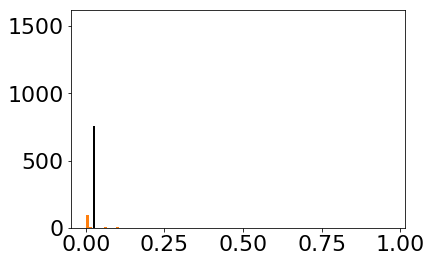

In [21]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [22]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

('GC3', 'MS-200109-16_S16') ('GC4', 'MS-200109-17_S17') 0.12052222405362345
('GC3', 'MS-200109-16_S16') ('GCb', 'MS-200109-19_S19') 0.07862326149417453
('GC4', 'MS-200109-17_S17') ('GC3', 'MS-200109-16_S16') 0.12052222405362345
('GC4', 'MS-200109-17_S17') ('GCb', 'MS-200109-19_S19') 0.08363045119331047
('GCb', 'MS-200109-19_S19') ('GC3', 'MS-200109-16_S16') 0.07862326149417453
('GCb', 'MS-200109-19_S19') ('GC4', 'MS-200109-17_S17') 0.08363045119331047
('Unknown', 'MS-85_S10') ('tonsil', 'MS-200109-1_S1') 0.03237768601692559
('Unknown', 'MS-85_S10') ('tonsil', 'MS-200109-7_S7') 0.03221031943416597
('tonsil', 'MS-200109-1_S1') ('Unknown', 'MS-85_S10') 0.03237768601692559
('tonsil', 'MS-200109-7_S7') ('Unknown', 'MS-85_S10') 0.03221031943416597
Wrote runMaria1234-similarity-IGH_HUMAN.txt to disk


In [23]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 5.161729902170009e-06
max value: 1.0
Wrote runMaria1234-similarity-IGH_HUMAN-highlighted.pdf to disk


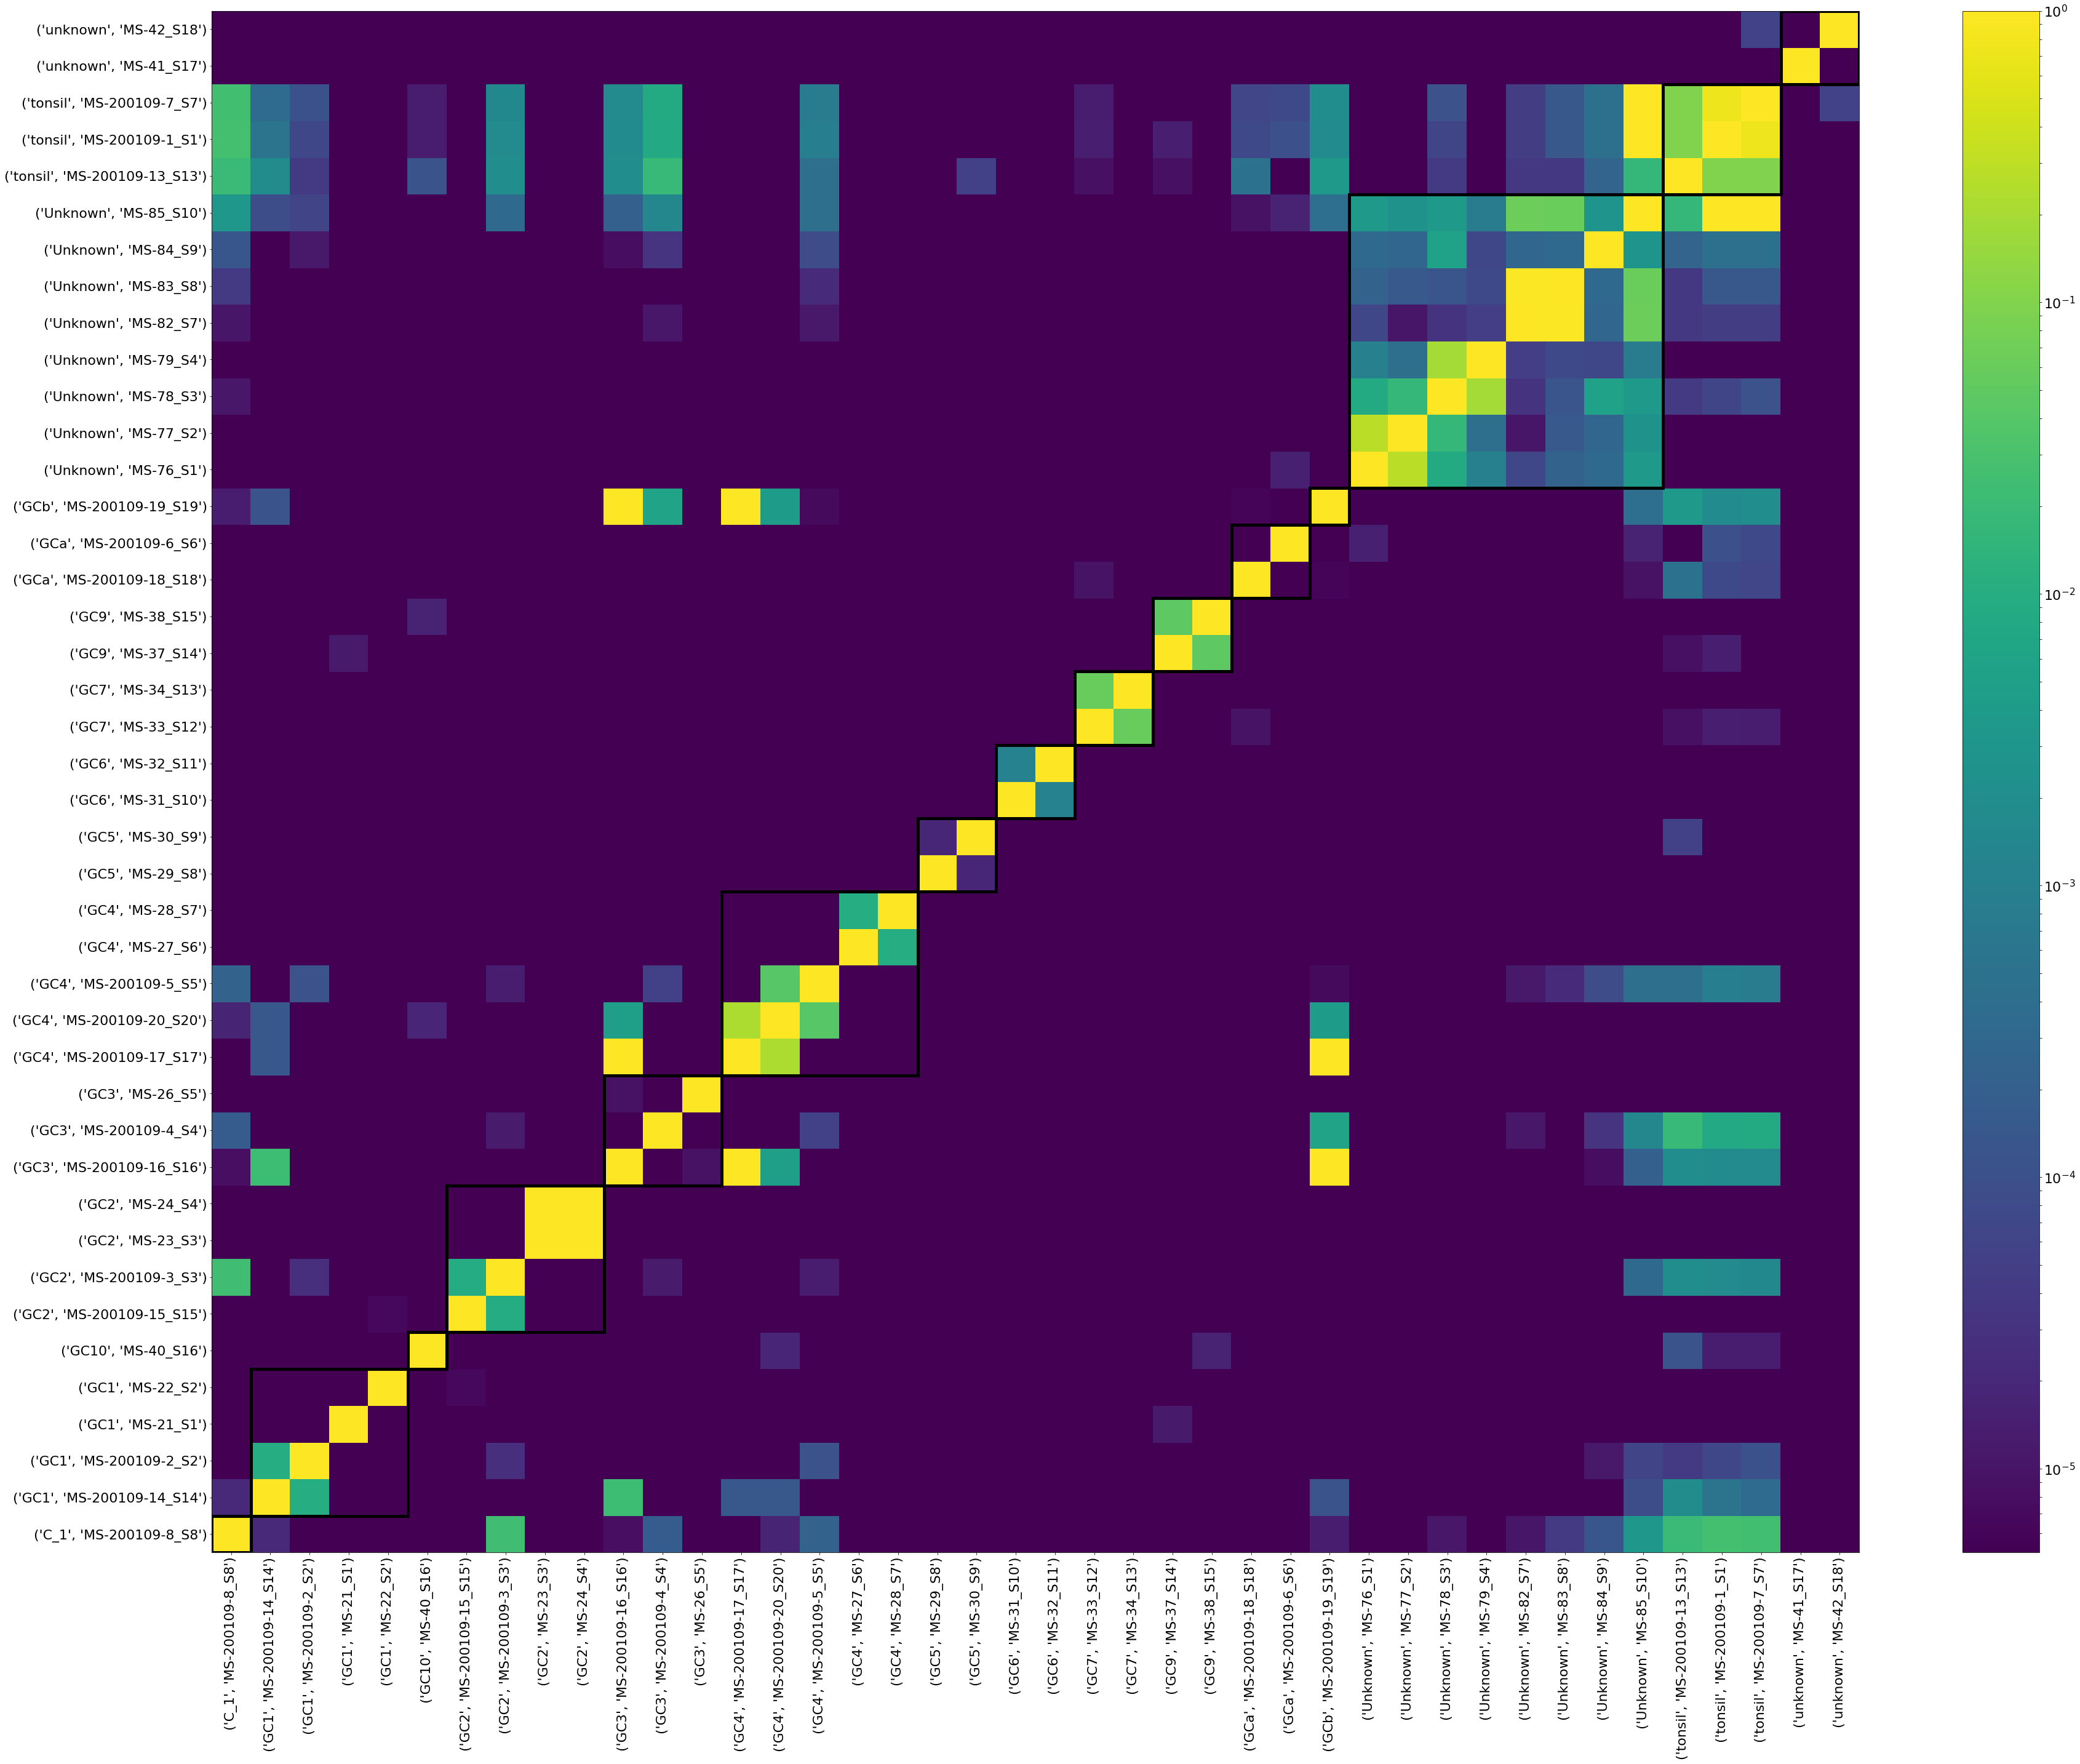

In [24]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)